#### sustainabiltiy based on feature stats analysis
- read feat_stats under "/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean"
- positive buoyancy measures, BL+ (area size of BL+, mean amplitude of BL+)

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [58]:
%%time
stats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean')

year_list = np.arange(2002,2020)

BLp_dtypes = []

for (duration_min, duration_max, duration_type) in zip([5,6,12,18,24],[6,12,18,24,72],
                                           ['SL','ML','LL','UL','UUL']):
    core_area_list = []
    mcs_area_list = []
    BL_TOT_mcs_list = []
    BL_CAPE_mcs_list = []
    BL_SUBSAT_mcs_list = []
    BLp_mean_amp_list = []
    BLp_area_list = []
    corr_coeff_temp_list = []
    
    for year in year_list:
    
        BLp_mean_stats = []
        data = xr.open_dataset(stats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
        
        mcs_duration = data.mcs_duration
        cond_1 = mcs_duration >= duration_min
        cond_2 = mcs_duration < duration_max
        track_sel = data.isel(tracks=np.where(cond_1 & cond_2)[0]).tracks
        
        # selected data with a specific duration range
        data_sub = data.sel(tracks=track_sel)
        
        # get BL+ varaibles 
        mcs_area = data_sub.ccs_area.values
        core_area = data_sub.core_area.values
        BL_TOT_mcs = data_sub.BL_TOT_mcs.values
        BL_CAPE_mcs = data_sub.BL_CAPE_mcs.values
        BL_SUBSAT_mcs = data_sub.BL_SUBSAT_mcs.values
        BLp_mean_amp = data_sub.BL_TOT_bp.values
        BLp_area = data_sub.BL_positive_area.values*25*25
        corr_coeff_temp = data_sub.corr_coeff_temp
        
        mcs_area_list.extend(mcs_area)
        core_area_list.extend(core_area)
        BLp_mean_amp_list.extend(BLp_mean_amp)
        BLp_area_list.extend(BLp_area)
        BL_TOT_mcs_list.extend(BL_TOT_mcs)
        BL_CAPE_mcs_list.extend(BL_CAPE_mcs)
        BL_SUBSAT_mcs_list.extend(BL_SUBSAT_mcs)
        corr_coeff_temp_list.extend(corr_coeff_temp)
        
    # recontruct into xarray dataset
    ds_xr = xr.Dataset(data_vars=dict(ccs_area=(['tracks','mcs_phase'], np.asarray(mcs_area_list)),
                                      core_area=(['tracks','mcs_phase'], np.asarray(core_area_list)),
                                      BLp_mean_amp = (['tracks','mcs_phase'], np.asarray(BLp_mean_amp_list)),
                                      BLp_area = (['tracks','mcs_phase'], np.asarray(BLp_area_list)),
                                      BL_TOT_mcs = (['tracks','mcs_phase'], np.asarray(BL_TOT_mcs_list)),
                                      BL_CAPE_mcs = (['tracks','mcs_phase'], np.asarray(BL_CAPE_mcs_list)),
                                      BL_SUBSAT_mcs = (['tracks','mcs_phase'], np.asarray(BL_SUBSAT_mcs_list)),
                                      corr_coeff_temp = (['tracks'], np.asarray(corr_coeff_temp_list))),
                             coords=dict(tracks=(['tracks'], np.arange(len(mcs_area_list))),
                                         mcs_phase=(['mcs_phase'], data.mcs_phase.values)))
    
    BLp_dtypes.append(ds_xr)   
BLp_merged = xr.concat(BLp_dtypes, pd.Index(['SL','ML','LL','UL','ULL'], name='duration_type'))       

CPU times: user 21.8 s, sys: 553 ms, total: 22.3 s
Wall time: 22.4 s


#### options for filtering tracks of high-P correlations

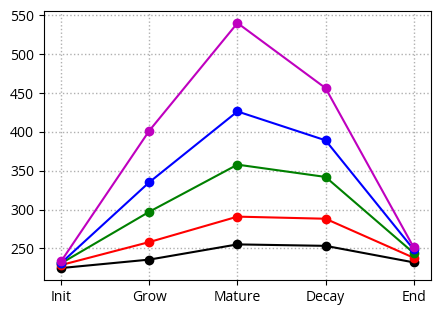

In [70]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ccolor = ['k','r','g','b','m']

for n,duration_type in enumerate(['SL','ML','LL','UL','ULL']):
    
    tmp = BLp_merged.sel(duration_type=duration_type).ccs_area.mean('tracks')
    ax.plot(tmp.mcs_phase, np.sqrt(tmp), '-o', color=ccolor[n])
ax.grid(linestyle=':', linewidth=1)

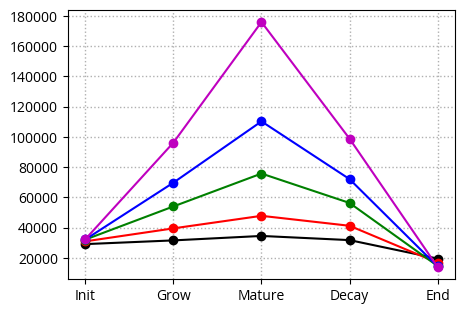

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ccolor = ['k','r','g','b','m']

for n,duration_type in enumerate(['SL','ML','LL','UL','ULL']):
    
    tmp = BLp_merged.sel(duration_type=duration_type).core_area.mean('tracks')
    ax.plot(tmp.mcs_phase, tmp, '-o', color=ccolor[n])
ax.grid(linestyle=':', linewidth=1)

Text(0.5, 1.0, 'non2MCS tracks, 2002-2020, tropics')

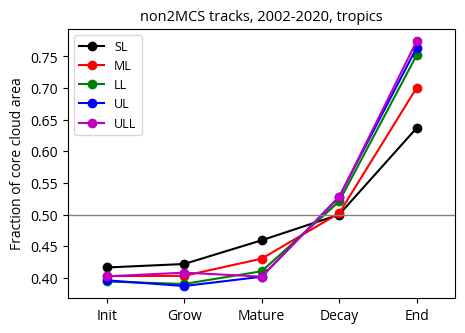

In [25]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ccolor = ['k','r','g','b','m']

for n,duration_type in enumerate(['SL','ML','LL','UL','ULL']):
    
    tmp = BLp_merged.sel(duration_type=duration_type).core_area # (area of Tb < 221 K)
    tmp2 = BLp_merged.sel(duration_type=duration_type).ccs_area # (area of Tb < 240 K)
    tmp3 = ((tmp2 - tmp)/tmp2).mean('tracks')
    ax.plot(tmp.mcs_phase, tmp3, '-o', color=ccolor[n], label=duration_type)
#ax.grid(linestyle=':', linewidth=1)
ax.hlines(y=0.5, xmin=-0.5, xmax=4.5, color='grey', linewidth=1)
ax.set_ylabel('Fraction of core cloud area', fontsize=10)
ax.set_xlim([-0.5, 4.5])
ax.legend(fontsize=9)
ax.set_title('non2MCS tracks, 2002-2020, tropics', fontsize=10.5)

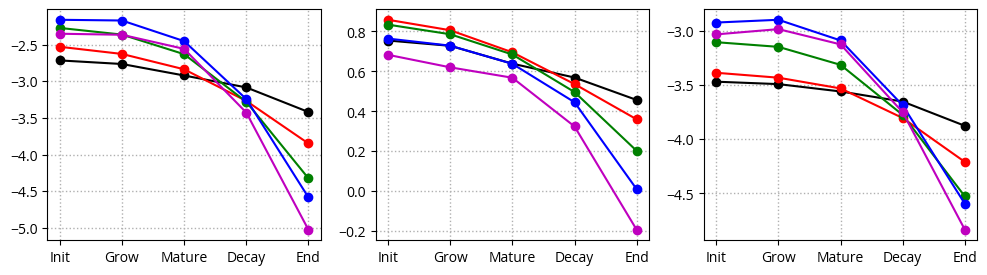

In [69]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

ccolor = ['k','r','g','b','m']
BL_TOT_mcs = 340*3/9.8*BLp_merged.BL_TOT_mcs
BL_CAPE_mcs = 340*3/9.8*BLp_merged.BL_CAPE_mcs
BL_SUBSAT_mcs = 340*3/9.8*BLp_merged.BL_SUBSAT_mcs

for i,(ax, data) in enumerate(zip([ax1,ax2,ax3],[BL_TOT_mcs, BL_CAPE_mcs, -BL_SUBSAT_mcs])):
    for n, duration_type in enumerate(['SL','ML','LL','UL','ULL']):
        
        # filter out higher tempeoral correlation between P-era5, P-GPM
        idx_HCC = np.where(BLp_merged.corr_coeff_temp.sel(duration_type=duration_type) > 0.7)[0]
        tmp = data.sel(duration_type=duration_type).isel(tracks=idx_HCC).mean('tracks')
        ax.plot(tmp.mcs_phase, tmp, '-o', color=ccolor[n])
        ax.grid(linestyle=':', linewidth=1)

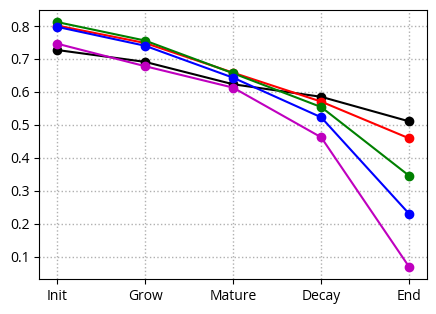

In [38]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ccolor = ['k','r','g','b','m']

for n,duration_type in enumerate(['SL','ML','LL','UL','ULL']):
    
    tmp = 340*3/9.8*BLp_merged.sel(duration_type=duration_type).BL_CAPE_mcs.mean('tracks')
    ax.plot(tmp.mcs_phase, tmp, '-o', color=ccolor[n])
ax.grid(linestyle=':', linewidth=1)

#### Buoyancy + stats

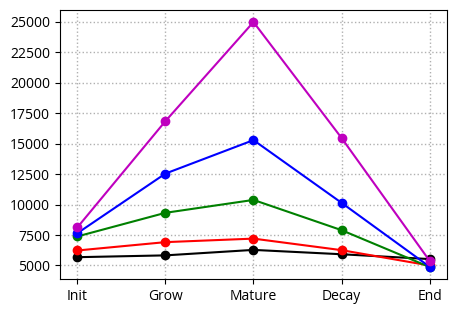

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ccolor = ['k','r','g','b','m']

for n,duration_type in enumerate(['SL','ML','LL','UL','ULL']):
    
    tmp = BLp_merged.sel(duration_type=duration_type).BLp_area.mean('tracks')
    ax.plot(tmp.mcs_phase, tmp, '-o', color=ccolor[n])
ax.grid(linestyle=':', linewidth=1)

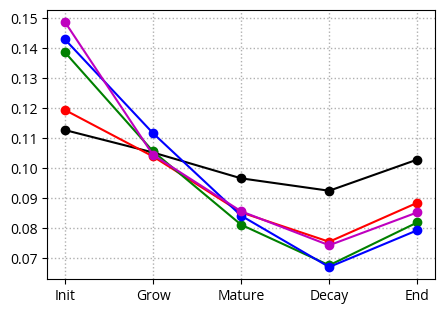

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ccolor = ['k','r','g','b','m']

for n,duration_type in enumerate(['SL','ML','LL','UL','ULL']):
    
    tmp = BLp_merged.sel(duration_type=duration_type).BLp_area.mean('tracks')
    tmp2 = BLp_merged.sel(duration_type=duration_type).ccs_area.mean('tracks')
    tmp3 = (tmp/tmp2)
    ax.plot(tmp.mcs_phase, tmp3, '-o', color=ccolor[n])
ax.grid(linestyle=':', linewidth=1)

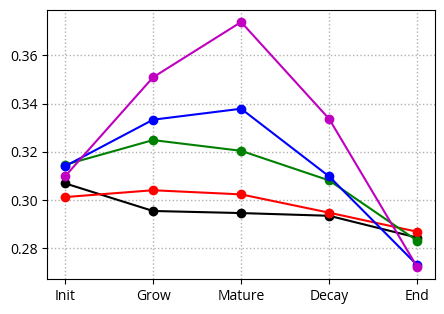

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ccolor = ['k','r','g','b','m']

for n,duration_type in enumerate(['SL','ML','LL','UL','ULL']):
    
    tmp = (340*3/9.8)*BLp_merged.sel(duration_type=duration_type).BLp_mean_amp.mean('tracks')
    ax.plot(tmp.mcs_phase, tmp, '-o', color=ccolor[n])
ax.grid(linestyle=':', linewidth=1)